In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from matplotlib.ticker import MultipleLocator, MaxNLocator
import seaborn as sns
from ast import literal_eval

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})

def load_and_prepare_results(dataset_name, suffix="features", lookahead=2, folds=None,
                             c_value=None, methods=None, remove_failed_runs=True, print_counts=True, 
                             combine_c_and_method=True, combine_opt_and_method=True, opt_crits=None,
                             scoreset_size=6):
    df = pd.read_csv(f"./results/results_{dataset_name}_{suffix}.csv")
    if remove_failed_runs and "exception" in df:
        df = df[df.exception.isna()]
    if c_value:
        df = df[df.c_value==c_value]
    if lookahead:
        df = df[df.lookahead.isin((lookahead, np.nan))]
    if methods:
        df = df[df.method.isin(methods)]
    if opt_crits:
        df = df[df.psl_optimization_metric.isin(opt_crits)]
    match folds:
        case int():
            df = df[df.fold<folds]
        case list():
            df = df[df.fold.isin(folds)]
        case _:
            pass
    if "c_value" in df.columns and combine_c_and_method:
        df["c_value"] = df["c_value"].fillna(" ")
        df["method"] = df["method"] + " " + df["c_value"].astype("str")
    if combine_opt_and_method:
        df["psl_optimization_metric"] = df["psl_optimization_metric"].fillna(" ")
        df["method"] = df["method"] + " " + df["psl_optimization_metric"].astype("str")
    df["lookahead"] = df["lookahead"].astype("str")
    df["score_set"] = df["score_set"].apply(literal_eval)
    df["score_set_size"] = df["score_set"].apply(len) 
    if scoreset_size:
        df =  df[df["score_set_size"] == scoreset_size]
    
    return df

def update_axes_tuple(axes, metric):
    axes[0].set_ylabel(f"{metric} in sample")
    axes[1].set_ylabel(f"{metric} out of sample")

    for ax in axes:
        ax.xaxis.set_major_locator(MaxNLocator(nbins="auto",steps=[1,2,3,5]))
        ax.set_xlabel("")
        if legend := ax.get_legend():
            legend.remove()
    
    axes[0].tick_params('y', labelleft=False, labelright=True)
    axes[1].tick_params('y', labelleft=False, labelright=False)
    axes[1].yaxis.set_label_position("right")
    axes[1].yaxis.get_label().set_visible(True)

# Feature Experiments
This section contains results from experiments with the number of features as a degree of complexity

In [2]:
datasets = [ "thorax", "covid", "adult", "breast", "heart"]
df = load_and_prepare_results(datasets[0])
display(set(df.psl_optimization_metric))
hue_order_train = ['expected_entropy_train','constrained_precision_train',  'accuracy_score_y_pred_train', 'balanced_accuracy_score_y_bal_train', 'f1_score_y_pred_train']
hue_order_test = [l.replace("_train", "_test") for l in hue_order_train]
display(df.columns)
cp = "Precision@0.9"

{' ',
 'accuracy',
 'balanced_accuracy',
 'constrained_precision',
 'expected_entropy'}

Index(['dataset', 'fold', 'score_set', 'method', 'c_value', 'stage',
       'features', 'scores', 'slim_threshold', 'solution_code',
       'accuracy_score_y_pred_train', 'accuracy_score_y_pred_test',
       'balanced_accuracy_score_y_pred_train',
       'balanced_accuracy_score_y_pred_test', 'precision_score_y_pred_train',
       'precision_score_y_pred_test', 'recall_score_y_pred_train',
       'recall_score_y_pred_test', 'f1_score_y_pred_train',
       'f1_score_y_pred_test', 'lookahead', 'psl_calibration_method',
       'psl_optimization_metric', 'brier_score_loss_train',
       'brier_score_loss_test', 'roc_auc_score_train', 'roc_auc_score_test',
       'constrained_precision_train', 'constrained_precision_test',
       'expected_entropy_train', 'expected_entropy_test',
       'accuracy_score_y_bal_train', 'accuracy_score_y_bal_test',
       'accuracy_score_cp_train', 'accuracy_score_cp_test',
       'balanced_accuracy_score_y_bal_train',
       'balanced_accuracy_score_y_bal_test

# Validation: Optimization Criterion of Slim and PSL equal (accuracy), how similar is performance

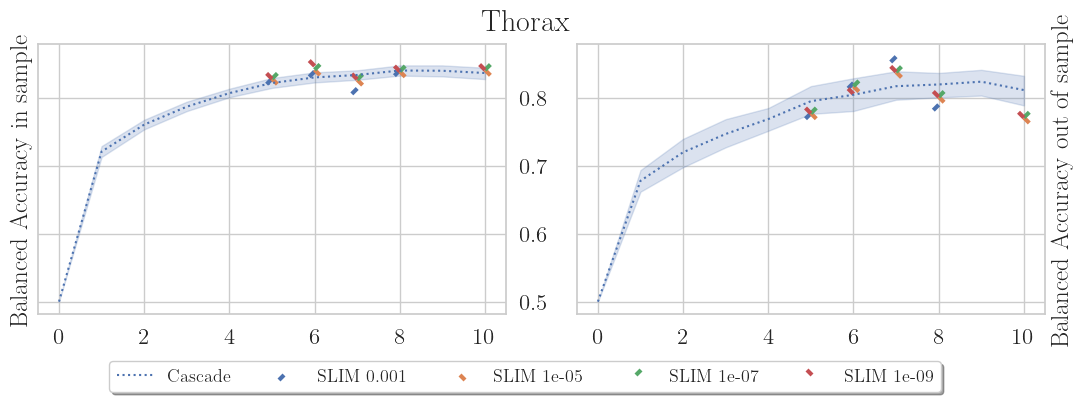

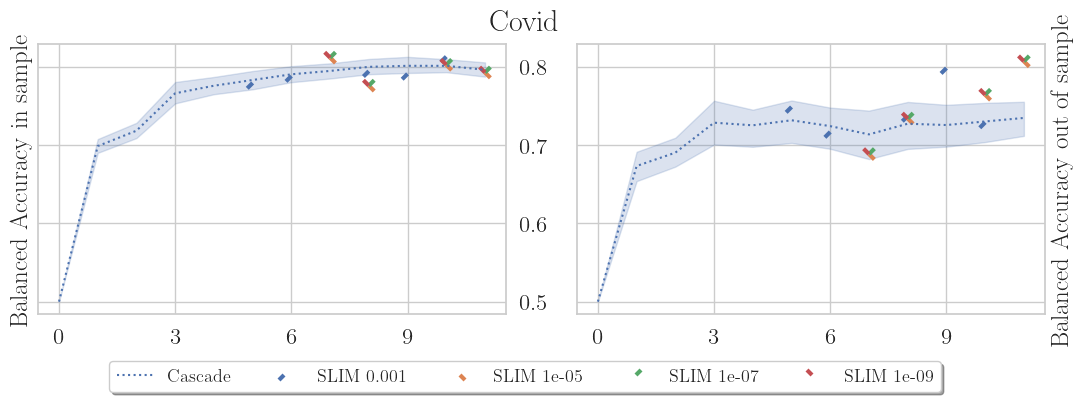

In [3]:
datasets = [ "thorax", "covid"]#, "mammo", "covid", "adult"]
for dataset_name in datasets:
    fig, axes = plt.subplots(1, 2, sharey=True, gridspec_kw=dict(wspace=.15))
    fig.set_size_inches(13, 3.5)
    axes = np.ravel(axes)
    train, test = "balanced_accuracy_score_y_bal_train", "balanced_accuracy_score_y_bal_test"
    
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], opt_crits=["balanced_accuracy"])
    results_slim = load_and_prepare_results(dataset_name=dataset_name, methods=["SLIM"])
    results_slim = results_slim[["stage","method","balanced_accuracy_score_y_pred_train","balanced_accuracy_score_y_pred_test"]].groupby(["stage","method"]).mean()
    markers = dict(markers=[MarkerStyle(0,"left",Affine2D().rotate_deg((i+.5)*90)) for i in range(4)], linewidth=3, s=30, style="method", hue="method")
    
    sns.lineplot(results_psl, x="stage", y=train, hue="method", ax=axes[0], legend="full", linestyle=":")
    sns.scatterplot(results_slim, x="stage", y="balanced_accuracy_score_y_pred_train", ax=axes[0], legend="full", **markers)
     
    sns.lineplot(results_psl, x="stage", y=test, hue="method", ax=axes[1],linestyle=":", legend=False)
    sns.scatterplot(results_slim, x="stage", y="balanced_accuracy_score_y_pred_test", ax=axes[1], legend=False, **markers)
    update_axes_tuple(axes,"Balanced Accuracy")
    
    handles, labels = axes[0].get_legend_handles_labels()
    labels = [l.replace("PSL   balanced_accuracy","Cascade") for l in labels]

    fig.suptitle(dataset_name.title())
    fig.legend(handles=handles,labels=labels,loc="upper center", bbox_to_anchor=(0.5, -0.0), fontsize=13, fancybox=True, shadow=True, ncol=6)
    fig.savefig(f"fig/{dataset_name}_optimality_of_greedy_(optmethod=bacc, eval=bacc).pdf", bbox_inches='tight')

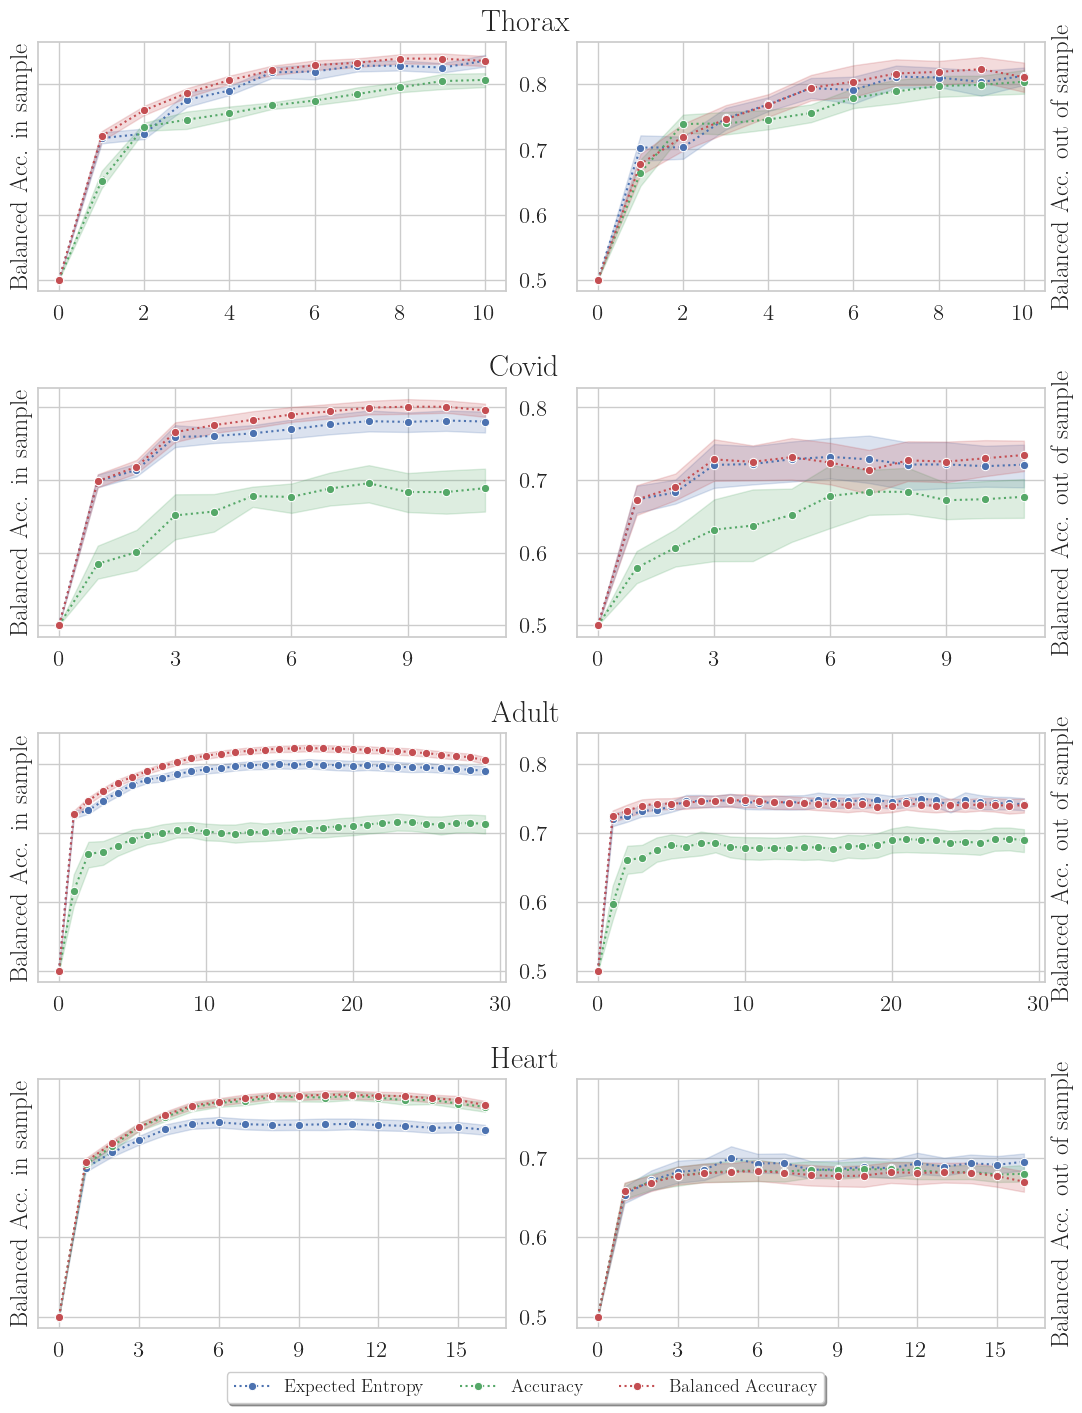

In [4]:
datasets = ["thorax", "covid", "adult", "heart"]

fig = plt.figure()
fig.set_size_inches(13,3.4*len(datasets))
subfigs = fig.subfigures(nrows=len(datasets), ncols=1, hspace=.07)

hue_order = [l.replace("_train", "").replace("_y_pred","").replace("_y_bal","").replace("_score","") for l in hue_order_train][:-1]

for i,dataset_name in enumerate(datasets):
    subfigs[i].suptitle(dataset_name.title())
    axes = subfigs[i].subplots(nrows=1, ncols=2, sharey=True, gridspec_kw=dict(wspace=.15))
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], opt_crits=["accuracy","balanced_accuracy","expected_entropy"])
    params = dict(data=results_psl, x="stage", hue="psl_optimization_metric", marker="o", linestyle=":", hue_order=hue_order)
    sns.lineplot(**params, y="balanced_accuracy_score_y_bal_train", ax=axes[0])
    sns.lineplot(**params, y="balanced_accuracy_score_y_bal_test", ax=axes[1], legend=False)
    update_axes_tuple(axes, "Balanced Acc.")

handles, labels = axes[0].get_legend_handles_labels()
# remove precision at k from legend
del handles[1]
del labels[1]
labels = [l.replace("_"," ").title() for l in labels]
fig.legend(handles=handles,labels = labels,loc="upper center", bbox_to_anchor=(0.5, -0.), fontsize=13, fancybox=True, shadow=True, ncol=5)
#fig.suptitle(f"Optimized for expected entropy: {dataset_name}")
plt.savefig(f"fig/all_opt_method_vs_bacc.pdf", bbox_inches='tight')

# Optimizing Expected Entropy and evaluating CP

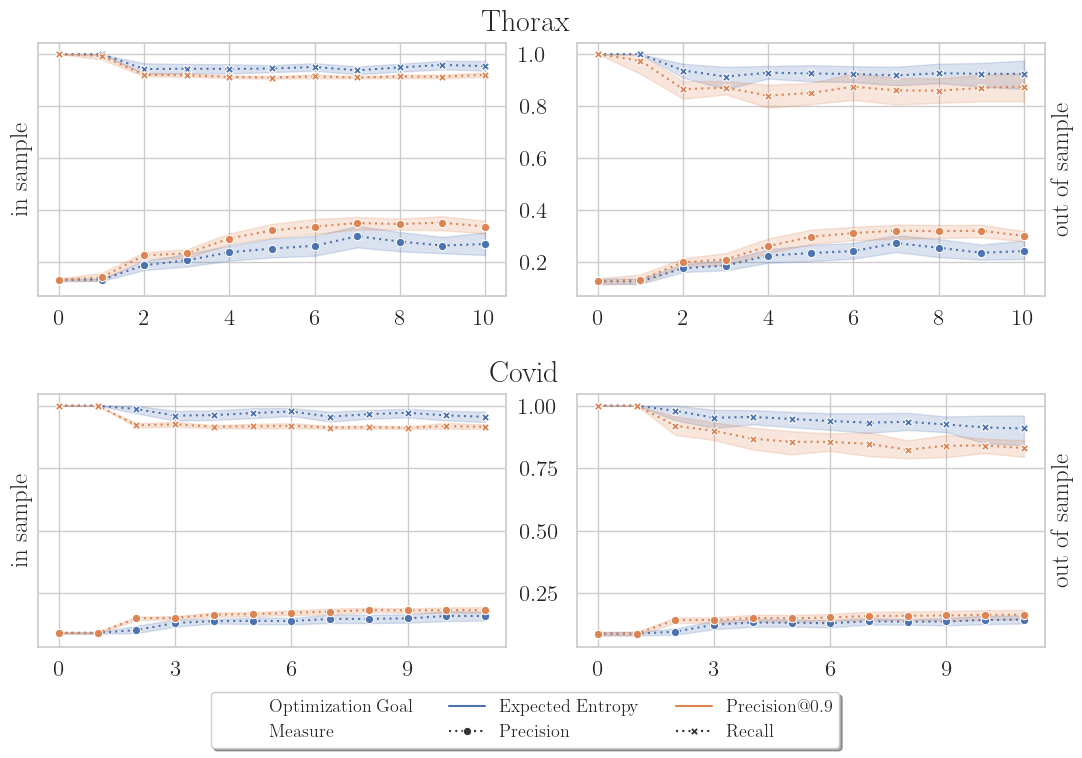

In [5]:
datasets = ["thorax", "covid"]

fig = plt.figure()
fig.set_size_inches(13,3.4*len(datasets))
subfigs = fig.subfigures(nrows=len(datasets), ncols=1, hspace=.07)

opt_crits = ["expected_entropy", "constrained_precision"]
metrics = ["precision_score_cp", "recall_score_cp"]
metrics_precise = [m + "_" + sample for sample in ["train","test"] for m in metrics]
plot_params= dict(x="stage", y="value", hue="psl_optimization_metric", style="metric", markers=True, dashes=[(1,2)]*len(metrics))

for i,dataset_name in enumerate(datasets):
    if not hasattr(subfigs, "__len__"):
        subfigs = [subfigs]
    subfigs[i].suptitle(dataset_name.title())
    axes = subfigs[i].subplots(nrows=1, ncols=2, sharey=True, gridspec_kw=dict(wspace=.15))
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], opt_crits=opt_crits)
    results_psl = results_psl.melt(id_vars=['fold', 'method',  'stage', "psl_optimization_metric"], value_vars=metrics_precise, var_name="metric", value_name="value")
    
    sns.lineplot(data=results_psl[results_psl.metric.str.endswith("train")], **plot_params, ax=axes[0])
    sns.lineplot(data=results_psl[results_psl.metric.str.endswith("test")], **plot_params, ax=axes[1], legend=False)
    update_axes_tuple(axes, "")

handle_label_pairs = list(zip(*axes[0].get_legend_handles_labels()))
# reshape
[handle_label_pairs.insert(3,(Patch(visible=False),"")) for _ in range(len(metrics)-len(opt_crits))]
handle_label_pairs = np.array(handle_label_pairs)
handles, labels = zip(*np.transpose(handle_label_pairs.reshape(2,-1,2), axes=[1,0,2]).reshape(-1,2).tolist())
labels = [l.replace("psl_optimization_metric","optimization_goal").replace("metric","measure").replace("_cp","").replace("_score","").replace("_train","").replace("_"," ").replace("constrained precision","Precision@0.9").title() for l in labels]
fig.legend(handles=handles,labels = labels,loc="upper center", bbox_to_anchor=(0.5, -0.), fontsize=13, fancybox=True, shadow=True, ncols=len(metrics)+1)
#fig.suptitle(f"Optimized for expected entropy: {dataset_name}")
plt.savefig(f"fig/optcp_optee_various_metrics.pdf", bbox_inches='tight')